# Random Forest: classify clinical control group based on microbiota

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

In [2]:
os.chdir(os.path.expanduser("~/Documents/Collaborations/sinusite_edwin/data"))

In [6]:
# === Set Parameters ===
timepoints = ["T0", "T1", "T3", "T6", "T12"]
abund_all = []
meta = pd.read_csv("metadata_filtered_Diversity.tsv", sep="\t")
print(meta)

       ID_Sample  SNOT22  SNOT22nasal  LK_Total  LK_Secret ClinicCtrl  AntUse  \
1    0001967K_T1    38.0         12.0       4.0        2.0         NC     1.0   
2    0001967K_T3    96.0         26.0      10.0        4.0         NC     1.0   
3    0001967K_T6    79.0         19.0       6.0        4.0         NC     1.0   
4    0088303G_T0   102.0         37.0       8.0        2.0         NC     NaN   
5    0088303G_T1    32.0          7.0       4.0        1.0         NC     1.0   
..           ...     ...          ...       ...        ...        ...     ...   
146  1654702B_T0    29.0         16.0       7.0        3.0         NC     NaN   
147  1654702B_T1     0.0          0.0       8.0        2.0         PC     1.0   
148  1654702B_T6     5.0          5.0       2.0        0.0         PC     1.0   
149  1668337K_T0    40.0         20.0      10.0        2.0         NC     NaN   
150  1668337K_T1    11.0          6.0       6.0        3.0         NC     1.0   

     Cortuse   Patient     

In [7]:
# === 1. Load and combine abundance data ===
for tp in timepoints:
    abund = pd.read_csv(f"Abund_by_Timepoint_4_Corr_{tp}.tsv", sep="\t", index_col=0)
    abund.index.name = "ID_Sample"
    abund.reset_index(inplace=True)
    
    abund["Timepoint"] = tp
    abund_all.append(abund)

abund_all = pd.concat(abund_all, ignore_index=True)
abund_merged = pd.merge(abund_all, meta, on="ID_Sample")

# Resolve the Timepoint column
abund_merged["Timepoint"] = abund_merged["Timepoint_x"]  # or Timepoint_y if you prefer
abund_merged = abund_merged.drop(columns=["Timepoint_x", "Timepoint_y"])

print(abund_merged)

        ID_Sample  Anaerococcus  Corynebacterium  Cutibacterium  \
0     0088303G_T0      0.601142         5.680794       0.150286   
1     0110059G_T0     11.048527         0.519931       5.892548   
2     0130765A_T0     10.679612         0.825243       1.165049   
3     0207720E_T0      0.765184         0.000000       0.191296   
4     0236549G_T0      0.718391        25.646552       0.862069   
..            ...           ...              ...            ...   
145  1552332D_T12      1.715686         1.252723       5.364924   
146  1560534I_T12      0.262123         5.111402       0.393185   
147  1567252D_T12      0.000000         0.000000       0.077821   
148  1578804D_T12      0.000000         0.000000       0.000000   
149  1605228B_T12      0.888889         0.148148       0.592593   

     Dolosigranulum  Finegoldia  Haemophilus  Incertae Sedis  Peptoniphilus  \
0         14.938383    0.811542     0.180343        1.172227       0.721371   
1          6.152513    5.632582     2

In [8]:
list(abund_merged.columns.values)

['ID_Sample',
 'Anaerococcus',
 'Corynebacterium',
 'Cutibacterium',
 'Dolosigranulum',
 'Finegoldia',
 'Haemophilus',
 'Incertae Sedis',
 'Peptoniphilus',
 'Porphyromonas',
 'Pseudomonas',
 'Staphylococcus',
 'Streptococcus',
 'Acinetobacter',
 'Aggregatibacter',
 'Neisseria',
 'Proteus',
 'Bacillus',
 'Burkholderia-Caballeronia-Paraburkholderia',
 'Dialister',
 'Enterobacter',
 'Escherichia-Shigella',
 'Fusobacterium',
 'Noviherbaspirillum',
 'Peptostreptococcus',
 'Prevotella',
 'Serratia',
 'Achromobacter',
 'Granulicatella',
 'Moraxella',
 'Pantoea',
 'Citrobacter',
 'Parvimonas',
 'Leptotrichia',
 'Mycoplasmoides',
 'SNOT22',
 'SNOT22nasal',
 'LK_Total',
 'LK_Secret',
 'ClinicCtrl',
 'AntUse',
 'Cortuse',
 'Patient',
 'Filename',
 'nreads',
 'Sex',
 'Age',
 'Atopic_Symptoms',
 'Asthma',
 'NSAID_Intolerance',
 'Total_IgE',
 'Blood_Eosinophilia',
 'Tissue_Eosinophilia',
 'Final_LundMackay',
 'Timepoint']

# assess whether the initial microbiota characteristics are associated with patient evolution after 12 months ######################################

In [54]:
# Define a patient evolution after 12 months

import pandas as pd

# --- Step 1: Extract Patient ID ---
abund_merged["Patient_ID"] = abund_merged["ID_Sample"].str.replace(r"_T\d+", "", regex=True)

# --- Step 2: Pivot to Get SNOT-22 Scores at T0 and T12 ---
snot_pivot = abund_merged.pivot_table(index="Patient_ID", 
                            columns="Timepoint", 
                            values="SNOT22")

# --- Step 3: Compute ΔSNOT-22 ---
snot_pivot["Delta_SNOT22"] = snot_pivot["T0"] - snot_pivot["T12"]


# --- Step 4: Classify Outcome Based on Threshold ---
snot_pivot["Outcome"] = snot_pivot["Delta_SNOT22"].apply(
    lambda x: "Good" if x >= 9 else "Bad"
)
snot_pivot = snot_pivot.dropna(subset=["Delta_SNOT22"])
snot_pivot

# --- Step 5: Merge Back into Main DataFrame ---
abund_merged2 = abund_merged.merge(snot_pivot[["Delta_SNOT22", "Outcome"]], on="Patient_ID", how="left")

In [58]:
abund_merged2 = abund_merged2.dropna(subset=["Delta_SNOT22"])
print(abund_merged2)

        ID_Sample  Anaerococcus  Corynebacterium  Cutibacterium  \
1     0110059G_T0     11.048527         0.519931       5.892548   
3     0207720E_T0      0.765184         0.000000       0.191296   
4     0236549G_T0      0.718391        25.646552       0.862069   
5     0313863D_T0      0.369359         1.188373       0.192709   
7     0492882D_T0      0.080364         0.000000       0.026788   
..            ...           ...              ...            ...   
144  1532317F_T12      0.092379         0.023095       0.138568   
145  1552332D_T12      1.715686         1.252723       5.364924   
146  1560534I_T12      0.262123         5.111402       0.393185   
147  1567252D_T12      0.000000         0.000000       0.077821   
149  1605228B_T12      0.888889         0.148148       0.592593   

     Dolosigranulum  Finegoldia  Haemophilus  Incertae Sedis  Peptoniphilus  \
1          6.152513    5.632582     2.729636        0.476603      21.490468   
3          0.119560    0.071736     0

In [59]:
# Prepare data 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import pandas as pd

# Define your features (X) and target (y)
X = abund_merged2.drop(columns=["ID_Sample", "Patient","Patient_ID", "SNOT22","Patient_ID", "Filename","nreads", "Delta_SNOT22", "Outcome", "Timepoint", "ClinicCtrl"])
y = abund_merged2["Outcome"]

# Encode outcome as binary: Good → 1, Bad → 0
y_encoded = y.map({"Good": 1, "Bad": 0})

In [62]:
# Train a model
## Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

## Fit a model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [63]:
# Calculate feature permutation importance
# Permutation importance (on test set)
result = permutation_importance(model, X_test, y_test, n_repeats=500, random_state=42)

# Convert to DataFrame
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": result.importances_mean,
    "Std": result.importances_std
}).sort_values(by="Importance", ascending=False)

print(importance_df.head(10))  # Show top 10 important features

                 Feature  Importance       Std
44             Total_IgE    0.143000  0.035389
47      Final_LundMackay    0.052250  0.025464
10        Staphylococcus    0.043833  0.030993
39                   Sex    0.033917  0.016213
40                   Age    0.026167  0.026008
46   Tissue_Eosinophilia    0.025750  0.020245
41       Atopic_Symptoms    0.021333  0.020827
20  Escherichia-Shigella    0.013583  0.019531
19          Enterobacter    0.009000  0.017146
9            Pseudomonas    0.006083  0.033142


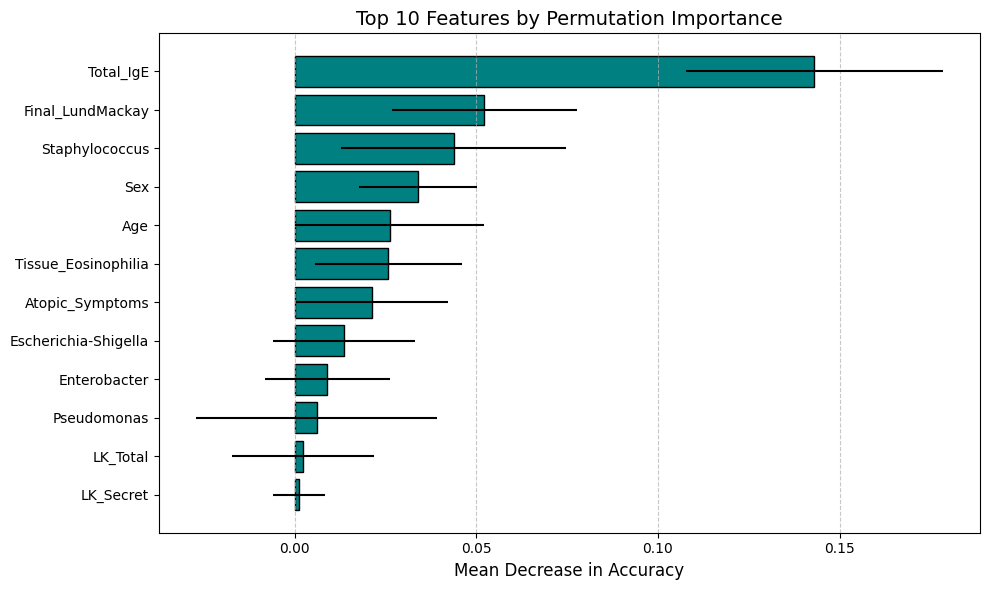

In [82]:
# Plotting Feature Importance
import matplotlib.pyplot as plt

# Filter top 15 features with non-zero importance
top_features = importance_df[importance_df["Importance"] > 0].sort_values(
    by="Importance", ascending=False
).head(15)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(
    top_features["Feature"],
    top_features["Importance"],
    xerr=top_features["Std"],
    color="teal",
    edgecolor="black"
)

plt.xlabel("Mean Decrease in Accuracy", fontsize=12)
plt.title("Top 10 Features by Permutation Importance", fontsize=14)
plt.gca().invert_yaxis()  # Highest importance at top
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Accuracy: 1.00


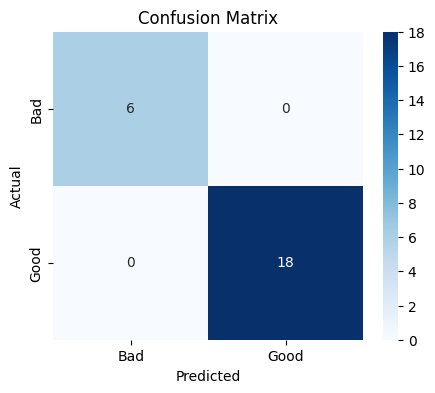

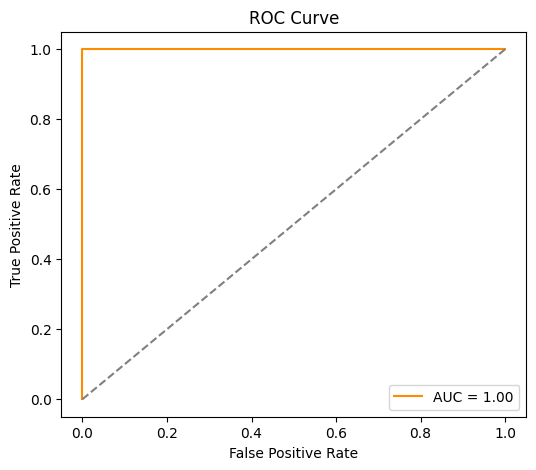

Classification Report:

              precision    recall  f1-score   support

         Bad       1.00      1.00      1.00         6
        Good       1.00      1.00      1.00        18

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



In [65]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define selected features
selected_features = [
    "Total_IgE",
    "Final_LundMackay",
    "Staphylococcus",
    "Sex",
    "Age",
    "Atopic_Symptoms"
]

# Prepare X and y
X = abund_merged2[selected_features]
y = abund_merged2["Outcome"].map({"Good": 1, "Bad": 0})  # Encode as binary

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probability for class 1 ("Good")

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Bad", "Good"]))

In [71]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=10, scoring="accuracy")
print("Cross-validation accuracy scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation accuracy scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean accuracy: 1.0


Accuracy (T0-trained model on future timepoints): 0.79
Classification Report:

              precision    recall  f1-score   support

         Bad       0.25      0.09      0.13        11
        Good       0.83      0.94      0.88        51

    accuracy                           0.79        62
   macro avg       0.54      0.52      0.51        62
weighted avg       0.73      0.79      0.75        62



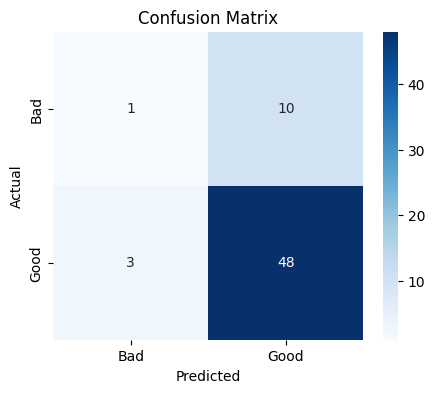

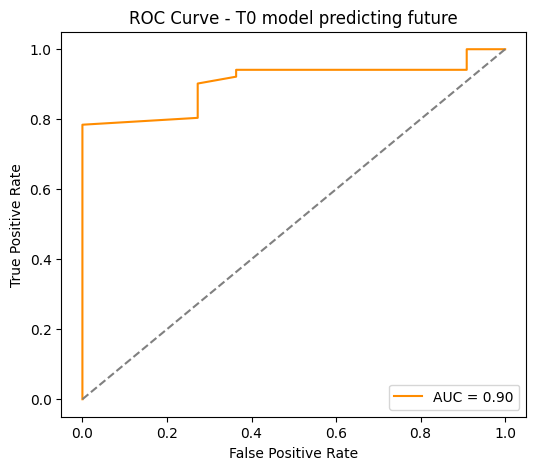

In [86]:
# Filter T0 samples for training
train_df = abund_merged2[abund_merged2["Timepoint"] == "T0"]
test_df = abund_merged2[abund_merged2["Timepoint"].isin(["T1", "T3", "T6", "T12"])]

# Define features and outcome
selected_features = [
    "Staphylococcus", "Final_LundMackay",
]

X_train = train_df[selected_features]
y_train = train_df["Outcome"].map({"Good": 1, "Bad": 0})

X_test = test_df[selected_features]
y_test = test_df["Outcome"].map({"Good": 1, "Bad": 0})

# Train model using only T0
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict evolution using later timepoints
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy (T0-trained model on future timepoints): {accuracy:.2f}")

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Bad", "Good"]))

# Confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - T0 model predicting future")
plt.legend(loc="lower right")
plt.show()

In [73]:
# Compute all ΔSNOT22 (T0 vs others)
delta_df = pd.DataFrame(index=snot_pivot.index)

for tp in ["T1", "T3", "T6", "T12"]:
    if tp in snot_pivot.columns:
        delta_df[f"Delta_{tp}"] = snot_pivot["T0"] - snot_pivot[tp]

delta_df

,Delta_T1,Delta_T3,Delta_T6,Delta_T12
Patient_ID,,,,
0110059G,NaN,47.0,32.0,47.0
0207720E,3.0,15.0,NaN,-9.0
0236549G,NaN,41.0,62.0,72.0
0313863D,69.0,69.0,NaN,71.0
0492882D,-15.0,19.0,-34.0,-9.0
0689227I,15.0,NaN,-45.0,37.0
0780068I,NaN,36.0,26.0,33.0
0980601G,26.0,-4.0,40.0,44.0
0990961D,18.0,7.0,19.0,22.0


/tmp/ipykernel_42942/1741886291.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_line = delta_long.groupby("Timepoint")["Delta_SNOT22"].mean()


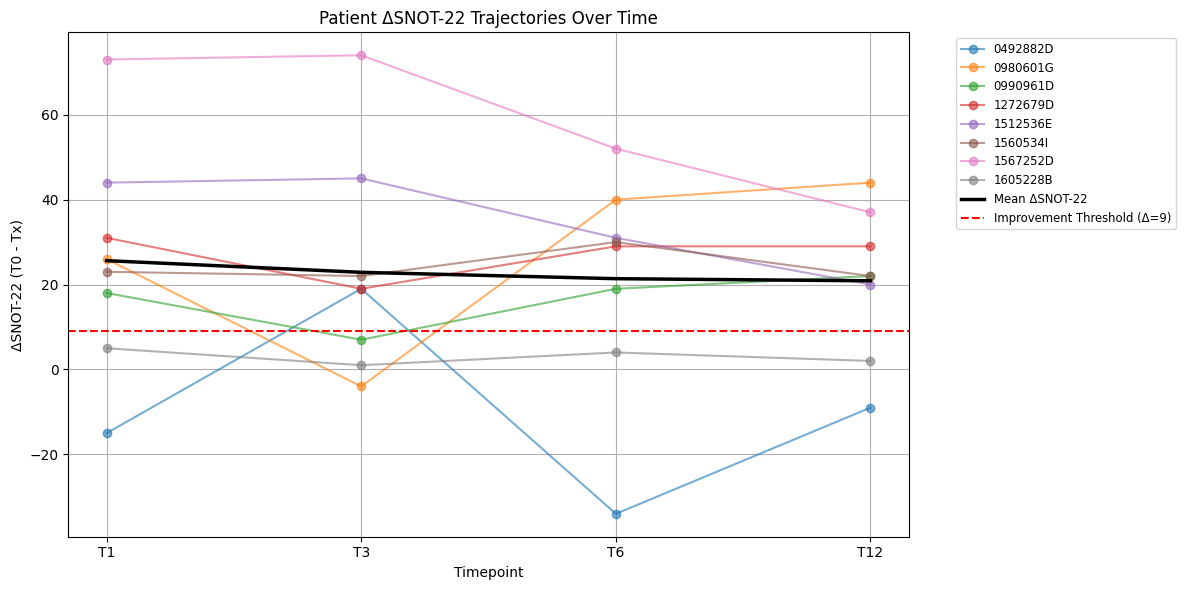

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

# Remove patients with any NaNs (in any Delta_T* column)
delta_clean = delta_df.dropna()

# Reshape the DataFrame to long format for easier plotting
delta_long = delta_clean.reset_index().melt(
    id_vars="Patient_ID", 
    value_vars=["Delta_T1", "Delta_T3", "Delta_T6", "Delta_T12"],
    var_name="Timepoint", 
    value_name="Delta_SNOT22"
)

# Clean timepoint labels for x-axis ordering
delta_long["Timepoint"] = delta_long["Timepoint"].str.replace("Delta_", "")
time_order = ["T1", "T3", "T6", "T12"]
delta_long["Timepoint"] = pd.Categorical(delta_long["Timepoint"], categories=time_order, ordered=True)

# Plot trajectories
plt.figure(figsize=(12, 6))
for patient_id, group in delta_long.groupby("Patient_ID"):
    plt.plot(group["Timepoint"], group["Delta_SNOT22"], marker="o", label=patient_id, alpha=0.6)

# Optional: highlight average line
avg_line = delta_long.groupby("Timepoint")["Delta_SNOT22"].mean()
plt.plot(time_order, avg_line, color='black', linewidth=2.5, label="Mean ΔSNOT-22")

# Plot aesthetics
plt.title("Patient ΔSNOT-22 Trajectories Over Time")
plt.xlabel("Timepoint")
plt.ylabel("ΔSNOT-22 (T0 - Tx)")
plt.axhline(y=9, color='red', linestyle='--', label="Improvement Threshold (Δ=9)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=1)
plt.tight_layout()
plt.grid(True)
plt.show()